Run on NERSC

In [2]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [3]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [4]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    ax.grid(alpha=0.5)
    return ax

In [5]:
ccd = fitsio.read('/global/project/projectdirs/cosmo/work/legacysurvey/dr9/reorg/survey-ccds-decam-dr9-newlocs2.fits.gz')
ccd = Table(ccd)
print(len(ccd))

# Load Schlegel's CCD file list
fn = '/global/project/projectdirs/cosmo/work/users/djschleg/dr9lists/dr9c.txt'
with open(fn, 'r') as f:
    lines = list(map(str.rstrip, f.readlines()))
print(len(lines))
# print(lines[0])

ccd['basename'] = list(map(os.path.basename, ccd['image_filename']))
mask = np.in1d(ccd['basename'], np.array(lines))
print(np.sum(mask)/len(mask))
ccd = ccd[mask]
print(len(ccd))

3560028
2191
0.0371909996214
132401


In [6]:
band = 'r'
field = 'south'
output_name = 'decals_ngc'

if (field=='north') and ((band=='g') or (band=='r')):
    pixscale_native = 0.454
else:
    pixscale_native = 0.262
# pixscale = 0.262 # pixscale for cutout queries

tmp = np.loadtxt('../data/{}_poly_fit.txt'.format(output_name))
band_index = np.where(band==np.array(['g', 'r', 'z']))[0][0]
poly = np.poly1d(tmp[band_index])
print(poly)
profile_fit = np.poly1d(poly)

          5          4        3         2
-0.02683 x - 0.4871 x + 2.31 x - 2.605 x - 2.965 x - 2.392


__Check that the fit works__

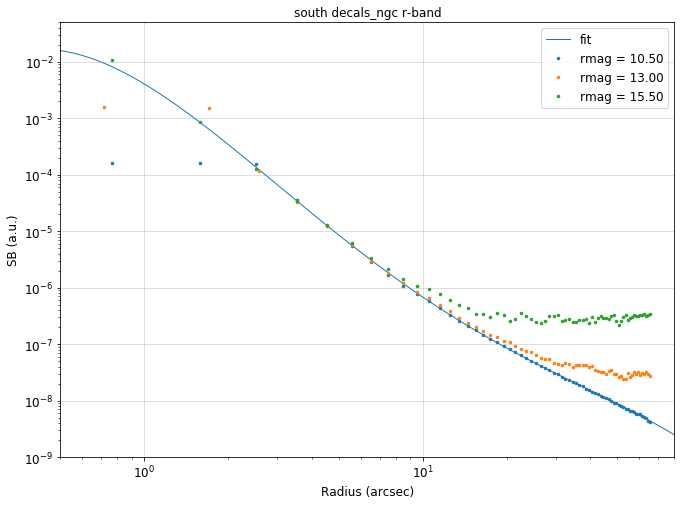

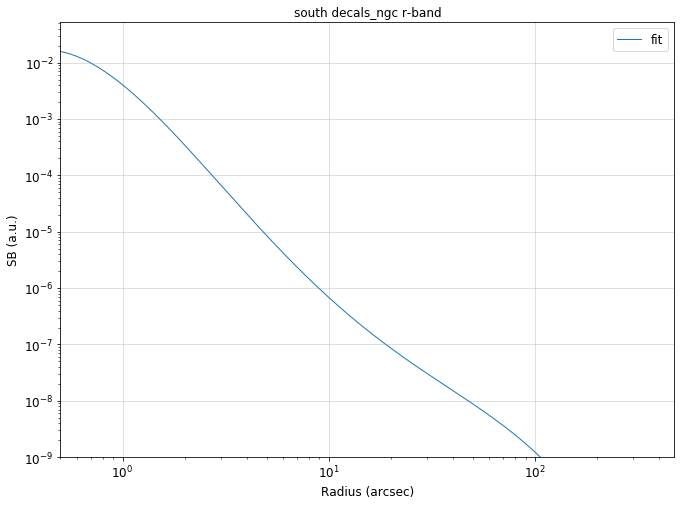

In [7]:
ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]

profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, output_name, band), format='ascii.commented_header')
indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, output_name, band))

xfit = np.logspace(-1, 2.5, 200)
yfit = 10**(profile_fit(np.log10(xfit)))

plt.figure(figsize=(11, 8))
plt.loglog(xfit, yfit, '-', lw=1., alpha=1., 
           label='fit', c='C0')
# for index in range(len(ls_mag_bins)):
for index in [0, 2, 4]:
    # normalize the flux to 22.5 magnitude stars
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
               label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]))
plt.title('{} {} {}-band'.format(field, output_name, band))
plt.axis([0.5, 80, 1e-9, 5e-2])
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.legend()
plt.show()

plt.figure(figsize=(11, 8))
plt.loglog(xfit, yfit, '-', lw=1., alpha=1., 
           label='fit', c='C0')
plt.title('{} {} {}-band'.format(field, output_name, band))
# plt.axis([0.5, 80, 1e-9, 5e-2])
plt.xlim(xmin=0.5)
plt.ylim(ymin=1e-9)
plt.grid(alpha=0.5)
plt.xlabel('Radius (arcsec)')
plt.ylabel('SB (a.u.)')
plt.legend()
plt.show()

In [8]:
ccd_mask = ccd['filter']==band
print(np.sum(ccd_mask))

43276


--------
## Check the fraction of flux within a specific radius

radius_cut = 6.00 arcsec
median = 0.24%
95th percentile = 0.43%
99th percentile = 0.55%


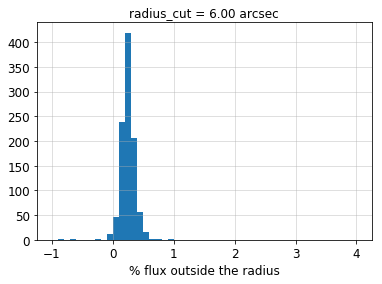

In [8]:
radius_cut = 6 # arcsec

idx = np.where(ccd_mask)[0]
nsamp = 1000
# nsamp = 10
if len(idx)>nsamp:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nsamp, replace=False)
    
idx = idx[np.argsort(ccd['expnum'][idx])]

frac_list = np.zeros(nsamp)

for index, ccd_index in enumerate(idx):

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # # normalize to a 22.5 magnitude star
    # # print(np.sum(psf0))
    # psf0 = psf0/np.sum(psf0)
      
    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()
    
    mask_img = radius_grid<radius_cut
    psf0_m = psf0.copy()
    psf0_m[~mask_img] = np.nan
    
    frac_list[index] = np.sum(psf0[~mask_img])/np.sum(psf0)
    # print('{} {} {}; FWHM = {:.2f}; {:.2f}% flux outside the radius'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index], 100*frac_list[index]))

print('radius_cut = {:.2f} arcsec'.format(radius_cut))
print('median = {:.2f}%'.format(100*np.median(frac_list)))
print('95th percentile = {:.2f}%'.format(np.percentile(100*frac_list, 95)))
print('99th percentile = {:.2f}%'.format(np.percentile(100*frac_list, 99)))
plt.hist(frac_list*100, 50, range=(-1, 4))
plt.xlabel('% flux outside the radius')
plt.title('radius_cut = {:.2f} arcsec'.format(radius_cut))
plt.grid(alpha=0.5)
plt.show()

radius_cut = 4.00 arcsec

fraction flux outside the radius
median = 1.00%
95th percentile = 1.71%
99th percentile = 2.24%


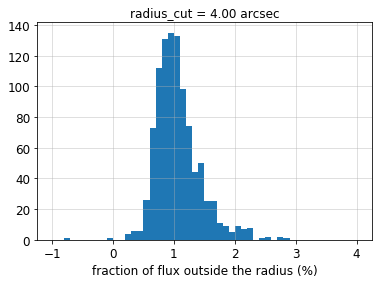

fractional difference
median = 0.04%


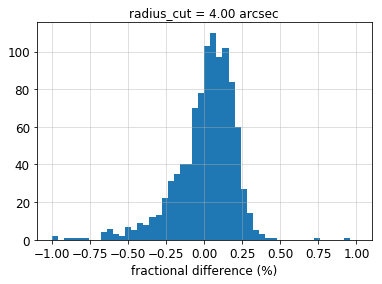

In [9]:
radius_cut = 4. # arcsec
##########################################
radius_lim1, radius_lim2 = 4., 5.
radius_lim3, radius_lim4 = 6., 6.8
##########################################

idx = np.where(ccd_mask)[0]
nsamp = 1000
# nsamp = 10
if len(idx)>nsamp:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nsamp, replace=False)
    
idx = idx[np.argsort(ccd['expnum'][idx])]

frac_list = np.zeros(nsamp)
diff_list = np.zeros(nsamp)

for index, ccd_index in enumerate(idx):

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # # normalize to a 22.5 magnitude star
    # # print(np.sum(psf0))
    # psf0 = psf0/np.sum(psf0)
     
    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img_fit = 10**(profile_fit(np.log10(radius_grid)))
        img_fit[~np.isfinite(img_fit)] = 0
    
    mask_img = radius_grid<radius_cut
    psf0_m = psf0.copy()
    psf0_m[~mask_img] = np.nan
    
    frac_list[index] = np.sum(psf0[~mask_img])/np.sum(psf0)
    # print('{} {} {}; FWHM = {:.2f}; {:.2f}% flux outside the radius'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index], 100*frac_list[index]))
    
    ###########################################################################
    
    psf0_combine = psf0.copy()
    
    r1, r2 = radius_lim1, radius_lim2
    mask = (radius_grid>r1) & (radius_grid<r2)
    psf0_combine[mask] = psf0[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + img_fit[mask] * (radius_grid[mask]-r1)/(r2-r1)
    
    r1, r2 = radius_lim2, radius_lim3
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psf0_combine[mask] = img_fit[mask]
    
    r1, r2 = radius_lim3, radius_lim4
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psf0_combine[mask] = img_fit[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + 0 * (radius_grid[mask]-r1)/(r2-r1)

    mask = (radius_grid>radius_lim4)
    psf0_combine[mask] = 0
    
    mask = radius_grid<=radius_lim3
    diff_list[index] = np.sum((psf0_combine-psf0)[mask])/np.sum(psf0[mask])
    
print('radius_cut = {:.2f} arcsec'.format(radius_cut))
print()

print('fraction flux outside the radius')
print('median = {:.2f}%'.format(100*np.median(frac_list)))
print('95th percentile = {:.2f}%'.format(np.percentile(100*frac_list, 95)))
print('99th percentile = {:.2f}%'.format(np.percentile(100*frac_list, 99)))
plt.hist(frac_list*100, 50, range=(-1, 4))
plt.xlabel('fraction of flux outside the radius (%)')
plt.title('radius_cut = {:.2f} arcsec'.format(radius_cut))
plt.grid(alpha=0.5)
plt.show()

print('fractional difference')
print('median = {:.2f}%'.format(100*np.median(diff_list)))
plt.hist(diff_list*100, 50, range=(-1 ,1))
plt.xlabel('fractional difference (%)')
plt.title('radius_cut = {:.2f} arcsec'.format(radius_cut))
plt.grid(alpha=0.5)
plt.show()

radius_cut = 4.50 arcsec

fraction flux outside the radius
median = 0.72%
95th percentile = 1.25%
99th percentile = 1.60%


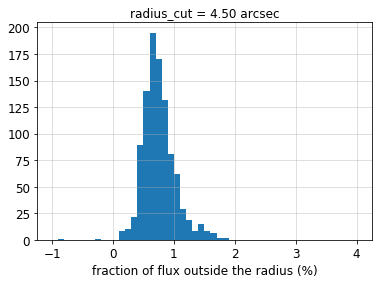

fractional difference
median = 0.03%


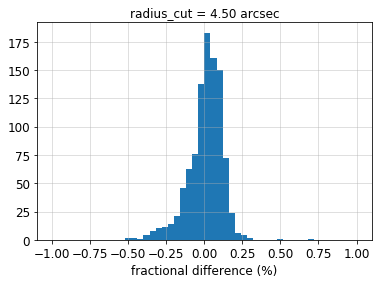

In [10]:
radius_cut = 4.5 # arcsec
##########################################
radius_lim1, radius_lim2 = 4.5, 5.5
radius_lim3, radius_lim4 = 6., 6.8
##########################################

idx = np.where(ccd_mask)[0]
nsamp = 1000
# nsamp = 10
if len(idx)>nsamp:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nsamp, replace=False)
    
idx = idx[np.argsort(ccd['expnum'][idx])]

frac_list = np.zeros(nsamp)
diff_list = np.zeros(nsamp)

for index, ccd_index in enumerate(idx):

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # # normalize to a 22.5 magnitude star
    # # print(np.sum(psf0))
    # psf0 = psf0/np.sum(psf0)
     
    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img_fit = 10**(profile_fit(np.log10(radius_grid)))
        img_fit[~np.isfinite(img_fit)] = 0

    mask_img = radius_grid<radius_cut
    psf0_m = psf0.copy()
    psf0_m[~mask_img] = np.nan
    
    frac_list[index] = np.sum(psf0[~mask_img])/np.sum(psf0)
    # print('{} {} {}; FWHM = {:.2f}; {:.2f}% flux outside the radius'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index], 100*frac_list[index]))
    
    ###########################################################################
    
    psf0_combine = psf0.copy()
    
    r1, r2 = radius_lim1, radius_lim2
    mask = (radius_grid>r1) & (radius_grid<r2)
    psf0_combine[mask] = psf0[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + img_fit[mask] * (radius_grid[mask]-r1)/(r2-r1)
    
    r1, r2 = radius_lim2, radius_lim3
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psf0_combine[mask] = img_fit[mask]
    
    r1, r2 = radius_lim3, radius_lim4
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psf0_combine[mask] = img_fit[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + 0 * (radius_grid[mask]-r1)/(r2-r1)

    mask = (radius_grid>radius_lim4)
    psf0_combine[mask] = 0
    
    mask = radius_grid<=radius_lim3
    diff_list[index] = np.sum((psf0_combine-psf0)[mask])/np.sum(psf0[mask])
    
print('radius_cut = {:.2f} arcsec'.format(radius_cut))
print()

print('fraction flux outside the radius')
print('median = {:.2f}%'.format(100*np.median(frac_list)))
print('95th percentile = {:.2f}%'.format(np.percentile(100*frac_list, 95)))
print('99th percentile = {:.2f}%'.format(np.percentile(100*frac_list, 99)))
plt.hist(frac_list*100, 50, range=(-1, 4))
plt.xlabel('fraction of flux outside the radius (%)')
plt.title('radius_cut = {:.2f} arcsec'.format(radius_cut))
plt.grid(alpha=0.5)
plt.show()

print('fractional difference')
print('median = {:.2f}%'.format(100*np.median(diff_list)))
plt.hist(diff_list*100, 50, range=(-1 ,1))
plt.xlabel('fractional difference (%)')
plt.title('radius_cut = {:.2f} arcsec'.format(radius_cut))
plt.grid(alpha=0.5)
plt.show()

-------
## Plot the combined image

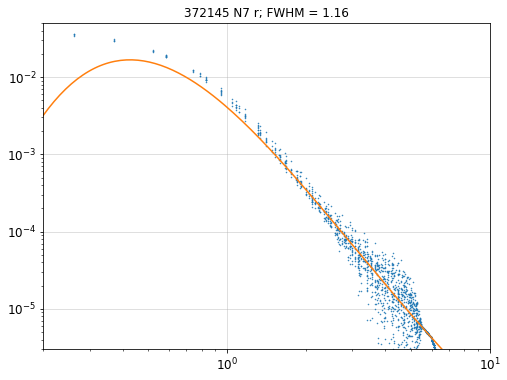

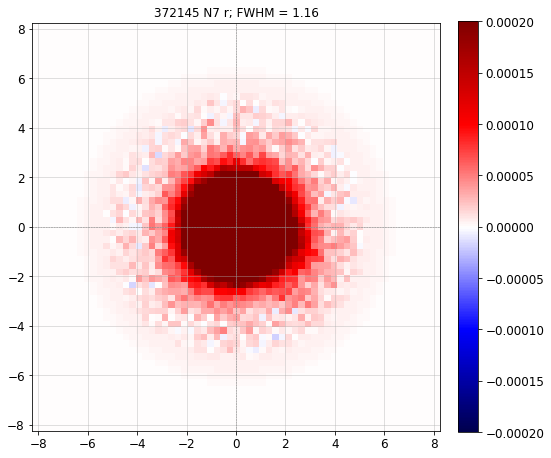

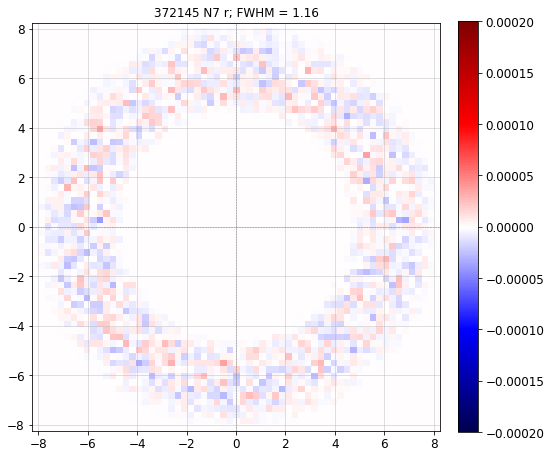

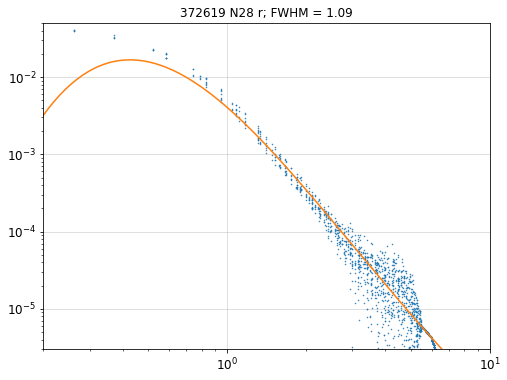

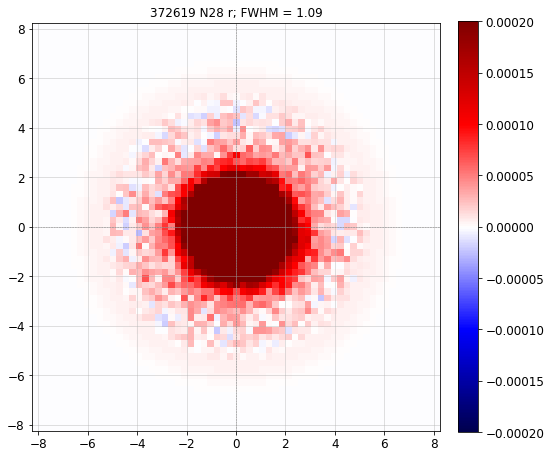

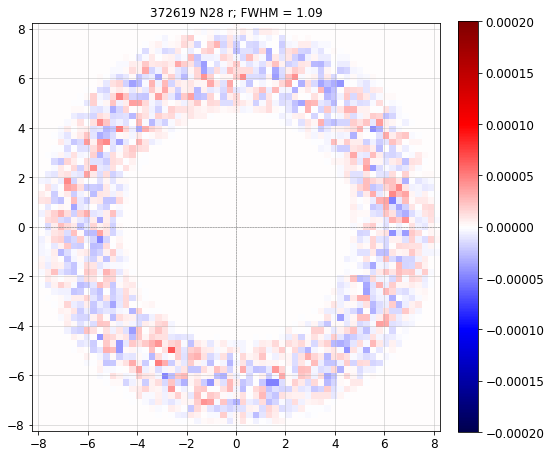

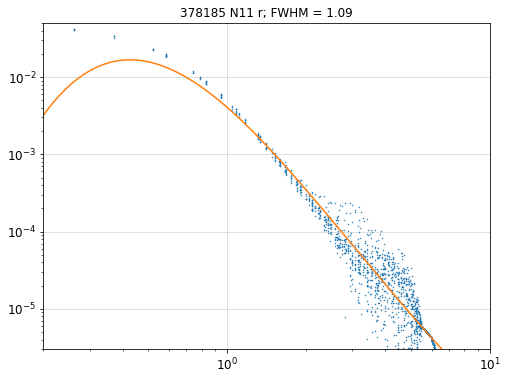

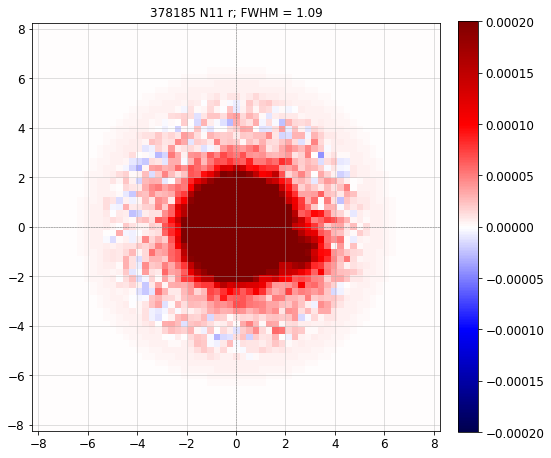

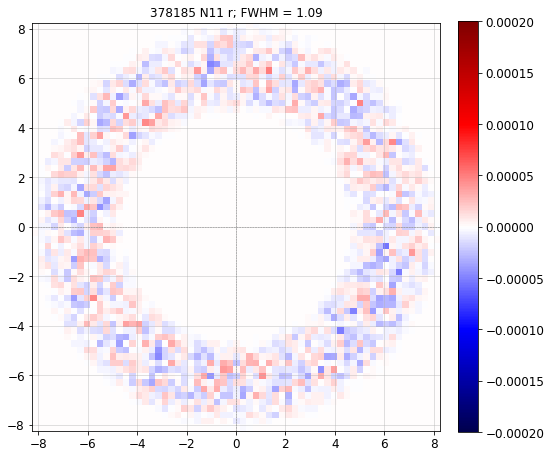

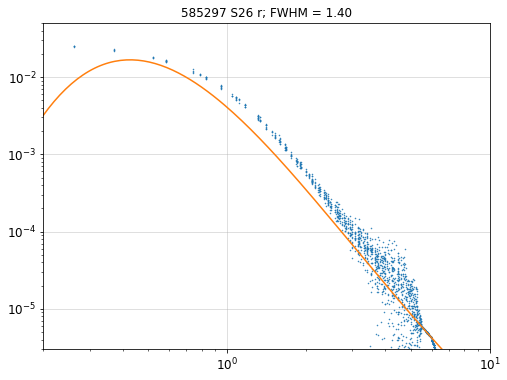

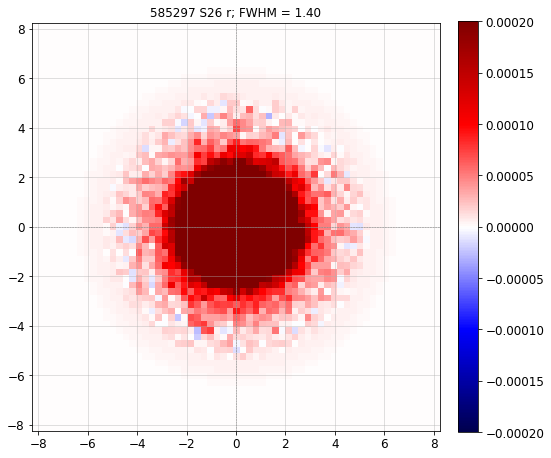

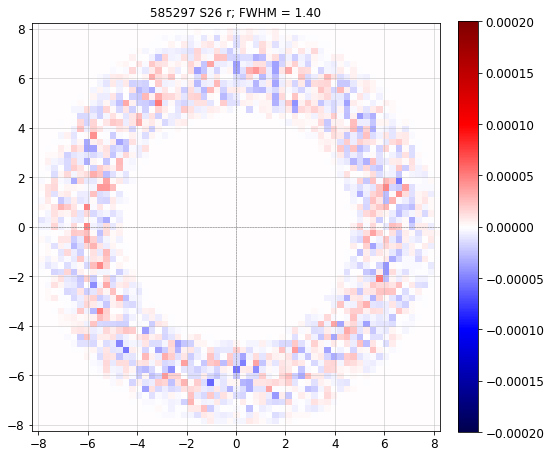

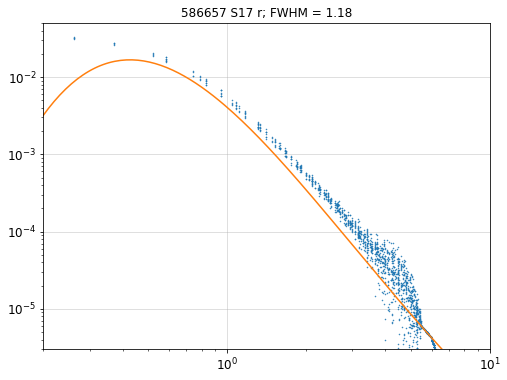

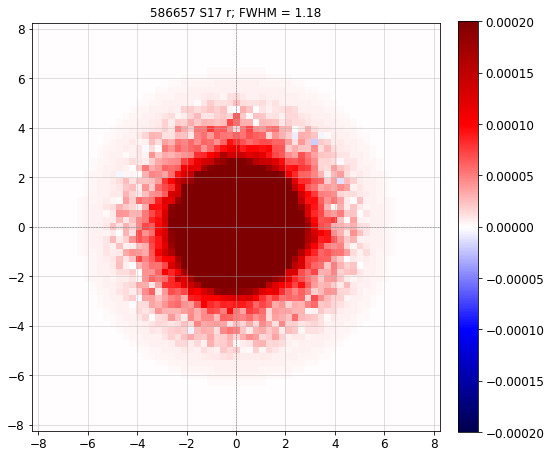

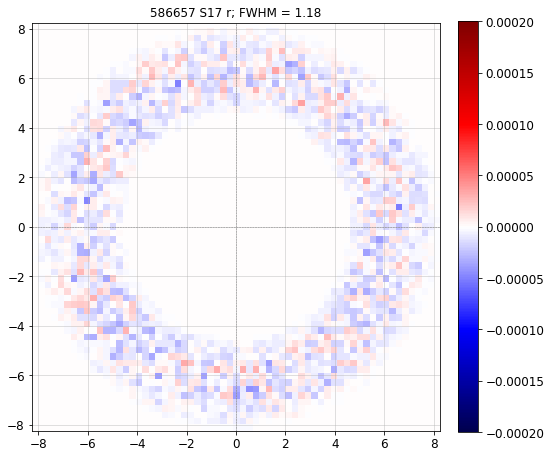

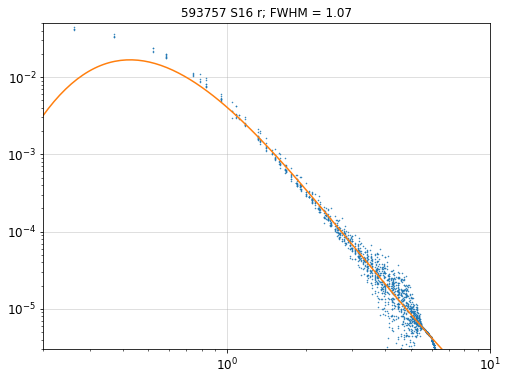

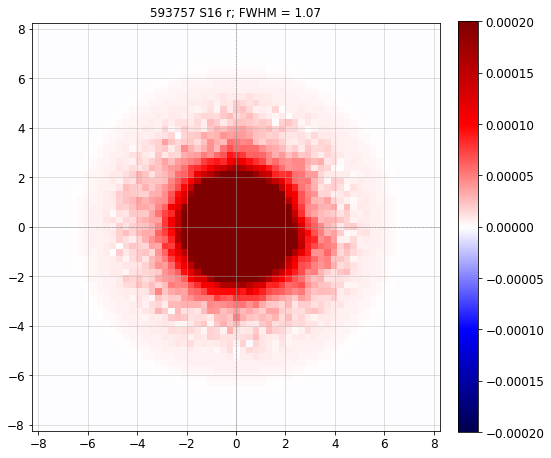

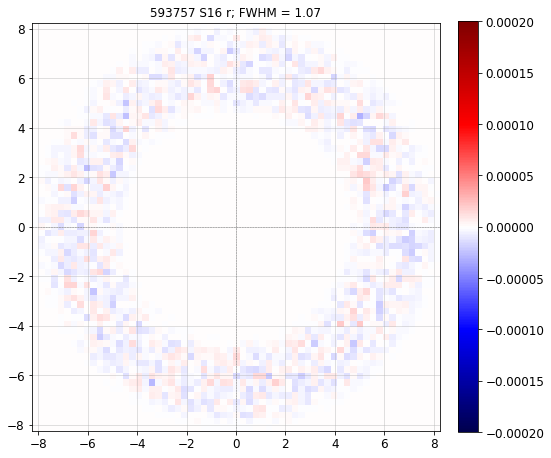

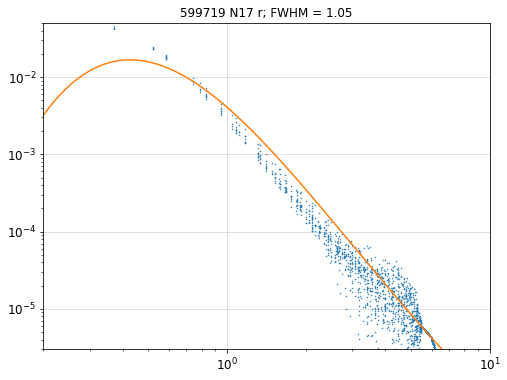

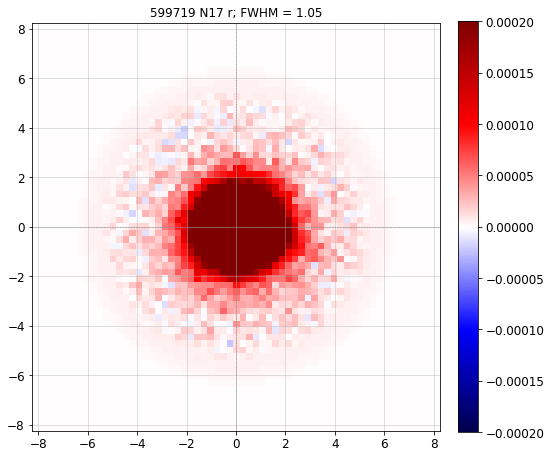

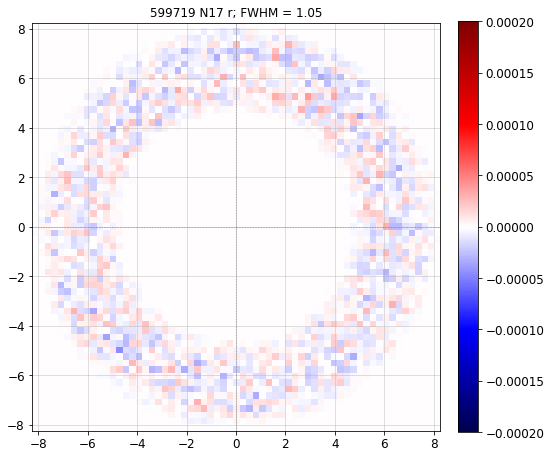

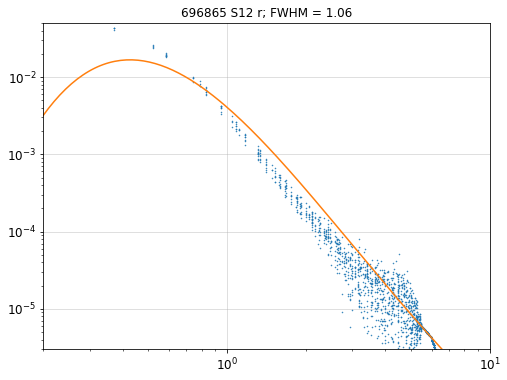

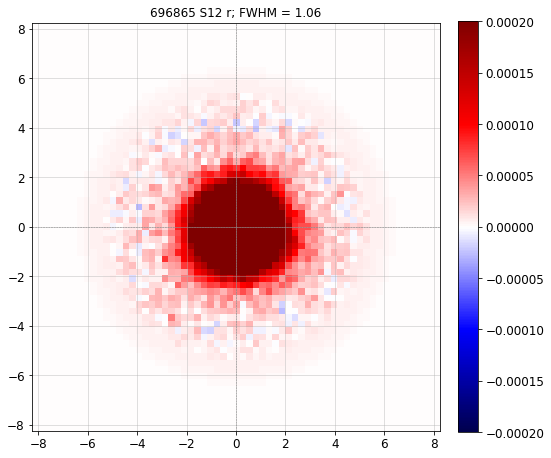

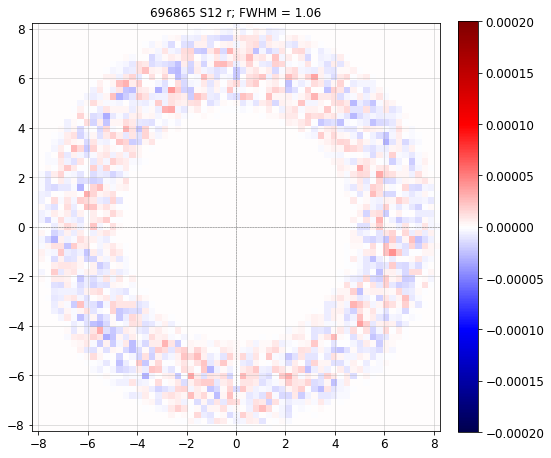

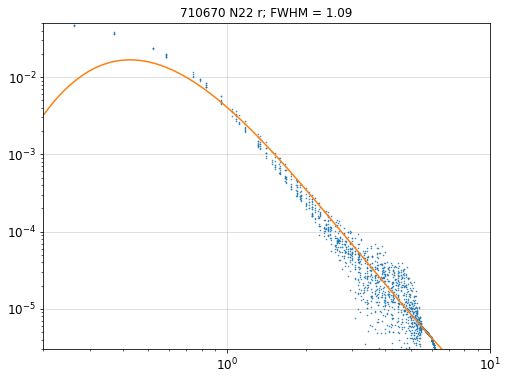

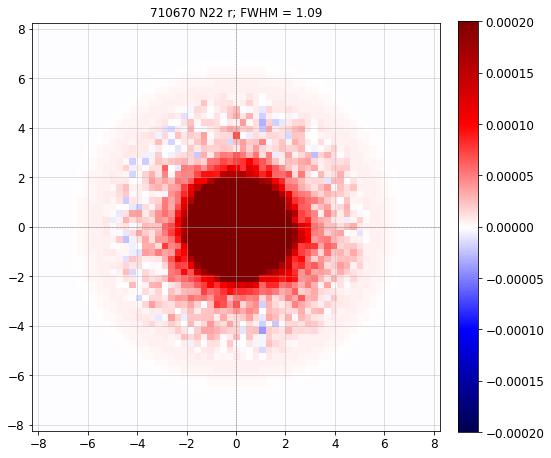

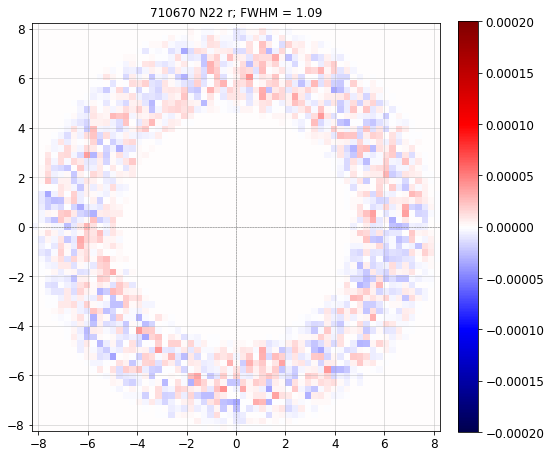

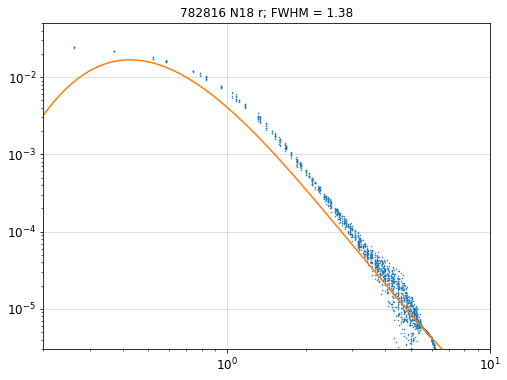

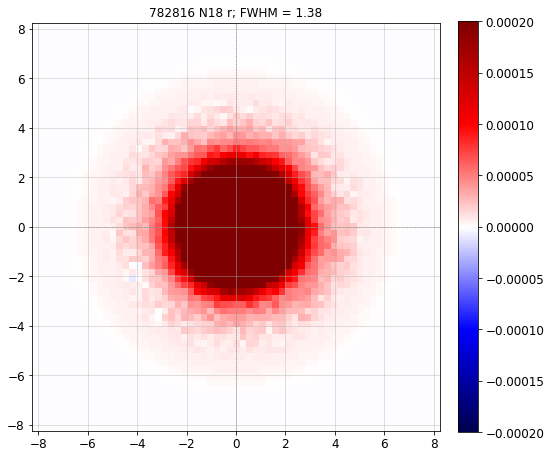

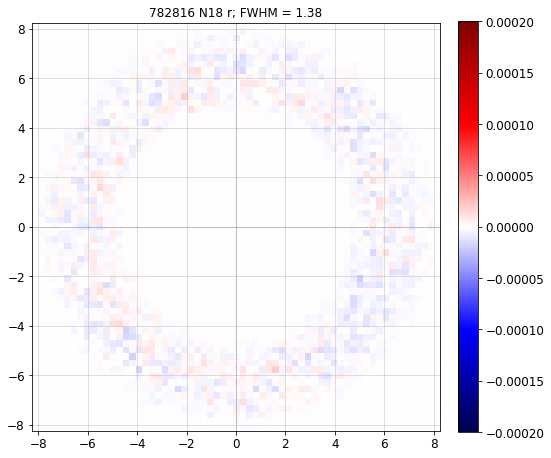

In [11]:
##########################################
radius_lim1, radius_lim2 = 4.5, 5.5
radius_lim3, radius_lim4 = 6., 6.8
##########################################

idx = np.where(ccd_mask)[0]
# nsamp = 1000
nsamp = 10
if len(idx)>nsamp:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nsamp, replace=False)

idx = idx[np.argsort(ccd['expnum'][idx])]

frac_list = np.zeros(nsamp)
for index, ccd_index in enumerate(idx):

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # # normalize to a 22.5 magnitude star
    # # print(np.sum(psf0))
    # psf0 = psf0/np.sum(psf0)
     
    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img_fit = 10**(profile_fit(np.log10(radius_grid)))
        img_fit[~np.isfinite(img_fit)] = 0
        
    psf0_combine = psf0.copy()
    
    r1, r2 = radius_lim1, radius_lim2
    mask = (radius_grid>r1) & (radius_grid<r2)
    psf0_combine[mask] = psf0[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + img_fit[mask] * (radius_grid[mask]-r1)/(r2-r1)
    
    r1, r2 = radius_lim2, radius_lim3
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psf0_combine[mask] = img_fit[mask]
    
    r1, r2 = radius_lim3, radius_lim4
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psf0_combine[mask] = img_fit[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + 0 * (radius_grid[mask]-r1)/(r2-r1)

    mask = (radius_grid>radius_lim4)
    psf0_combine[mask] = 0
    
    x = np.logspace(-1, 10, 1000)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(8, 6))
        plt.loglog(radius, (psf0_combine).flatten(), '.', ms=1.)
        plt.loglog(x, 10**(profile_fit(np.log10(x))), '-', ms=1.)
        plt.axis([0.2, 10, 3e-6, 0.05])
        plt.grid(alpha=0.5)
        plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))
        plt.show()

    vrange = 0.0002
    plot_cutout(psf0_combine, pixscale_native, vmin=-vrange, vmax=vrange)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))
    plt.show()

    plot_cutout(psf0_combine-psf0, pixscale_native, vmin=-vrange, vmax=vrange)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))
    plt.show()

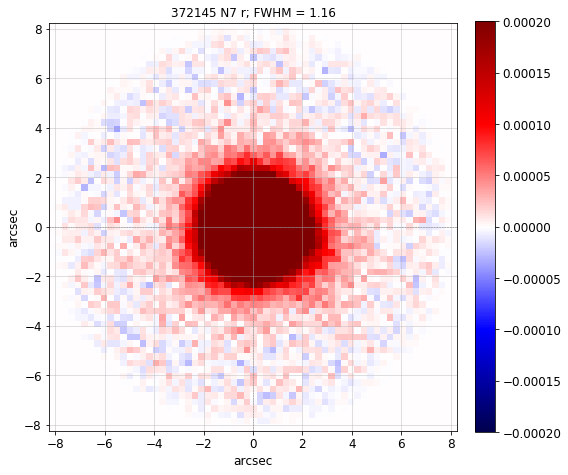

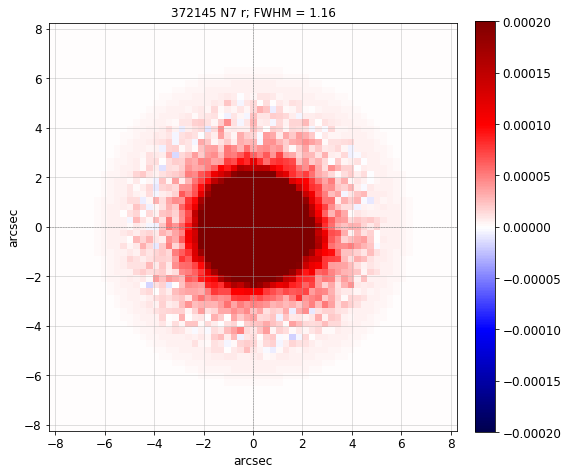

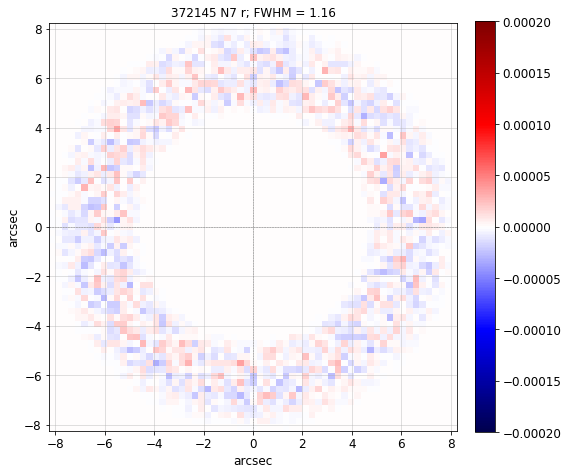

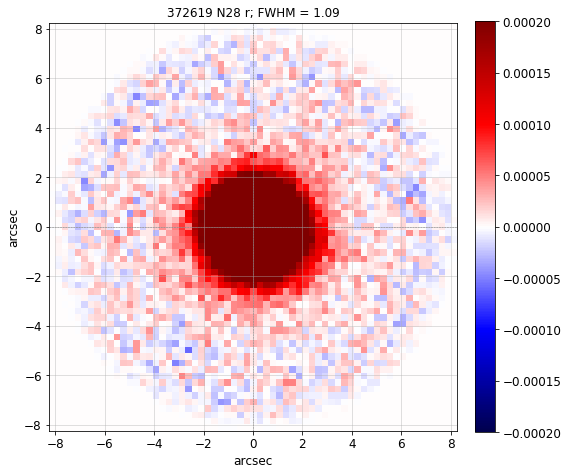

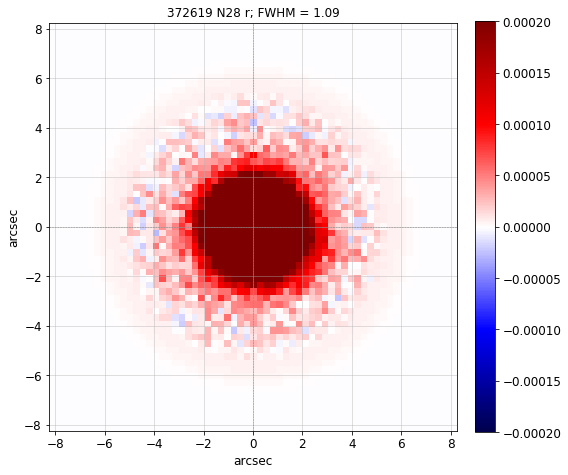

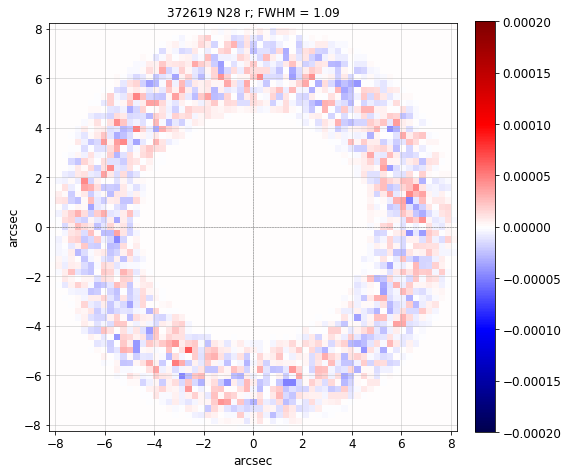

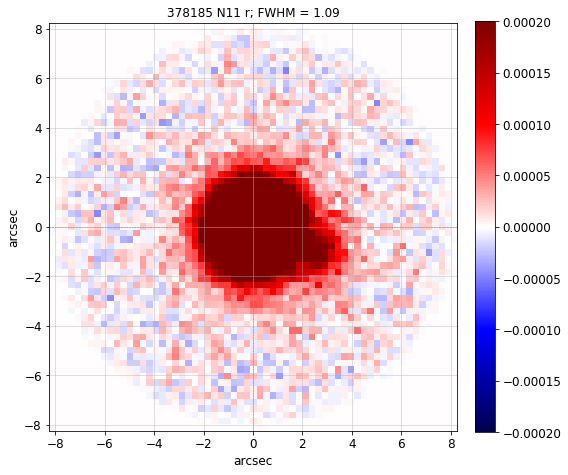

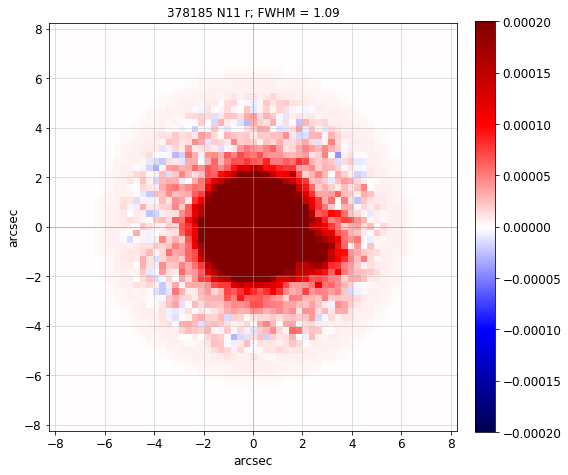

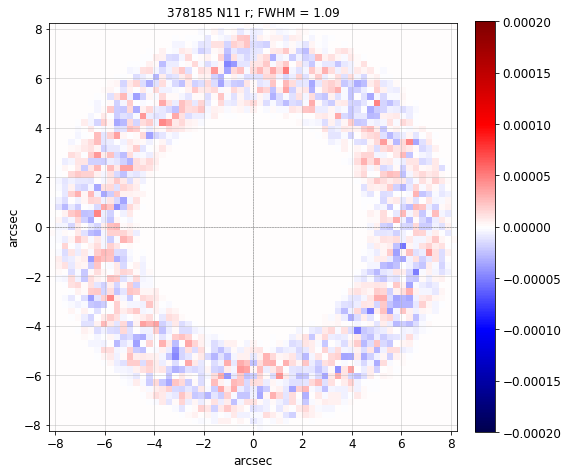

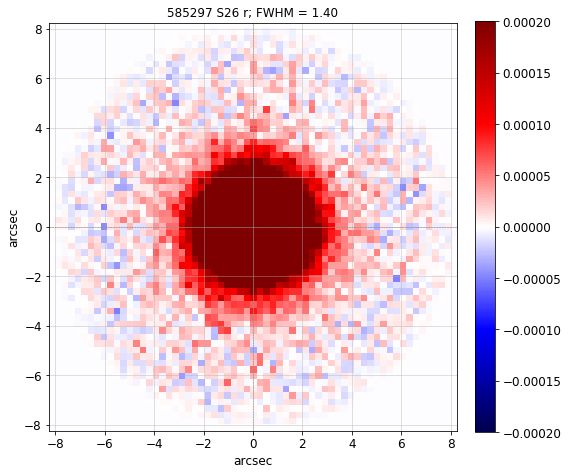

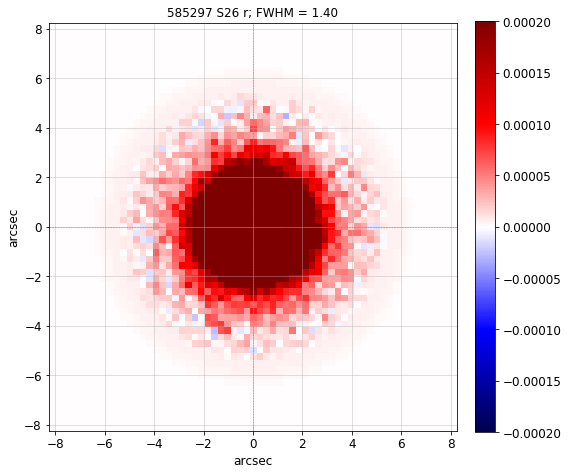

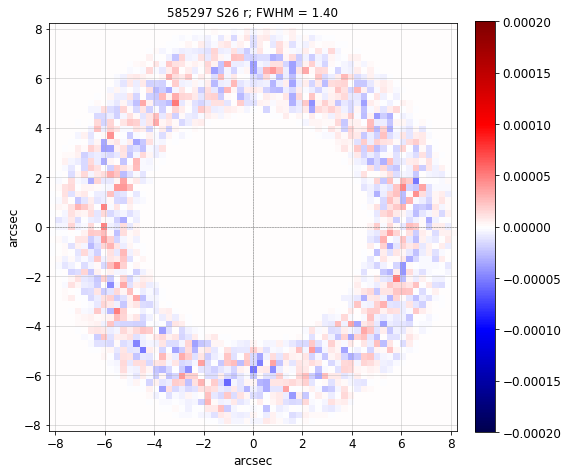

KeyboardInterrupt: 

In [10]:
##########################################
radius_lim1, radius_lim2 = 4.5, 5.5
radius_lim3, radius_lim4 = 6., 6.8
##########################################

idx = np.where(ccd_mask)[0]
# nsamp = 1000
nsamp = 10
if len(idx)>nsamp:
    np.random.seed(1)
    idx = np.random.choice(idx, size=nsamp, replace=False)

idx = idx[np.argsort(ccd['expnum'][idx])]

frac_list = np.zeros(nsamp)
for index, ccd_index in enumerate(idx):

    expnum = ccd['expnum'][ccd_index]
    ccdname = ccd['ccdname'][ccd_index]
    
    expnum_str = str(expnum)

    fn = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
    
    hdu = fits.open(fn)
    data = hdu[1].data
    # print(data['psf_mask'].shape)

    which_ccd = np.where(data['ccdname']==ccdname)[0][0]
    psf = data['psf_mask'][which_ccd]
    # print(psf.shape)

    psf0 = psf[0]
    # # normalize to a 22.5 magnitude star
    # # print(np.sum(psf0))
    # psf0 = psf0/np.sum(psf0)
     
    grid = pixscale_native * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img_fit = 10**(profile_fit(np.log10(radius_grid)))
        img_fit[~np.isfinite(img_fit)] = 0
        
    psf0_combine = psf0.copy()
    
    r1, r2 = radius_lim1, radius_lim2
    mask = (radius_grid>r1) & (radius_grid<r2)
    psf0_combine[mask] = psf0[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + img_fit[mask] * (radius_grid[mask]-r1)/(r2-r1)
    
    r1, r2 = radius_lim2, radius_lim3
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psf0_combine[mask] = img_fit[mask]
    
    r1, r2 = radius_lim3, radius_lim4
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psf0_combine[mask] = img_fit[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + 0 * (radius_grid[mask]-r1)/(r2-r1)

    mask = (radius_grid>radius_lim4)
    psf0_combine[mask] = 0

    vrange = 0.0002
    
    plot_cutout(psf0, pixscale_native, vmin=-vrange, vmax=vrange)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    plt.show()

    plot_cutout(psf0_combine, pixscale_native, vmin=-vrange, vmax=vrange)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    plt.show()

    plot_cutout(psf0_combine-psf0, pixscale_native, vmin=-vrange, vmax=vrange)
    plt.title('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, band, pixscale_native*ccd['fwhm'][ccd_index]))
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    plt.show()